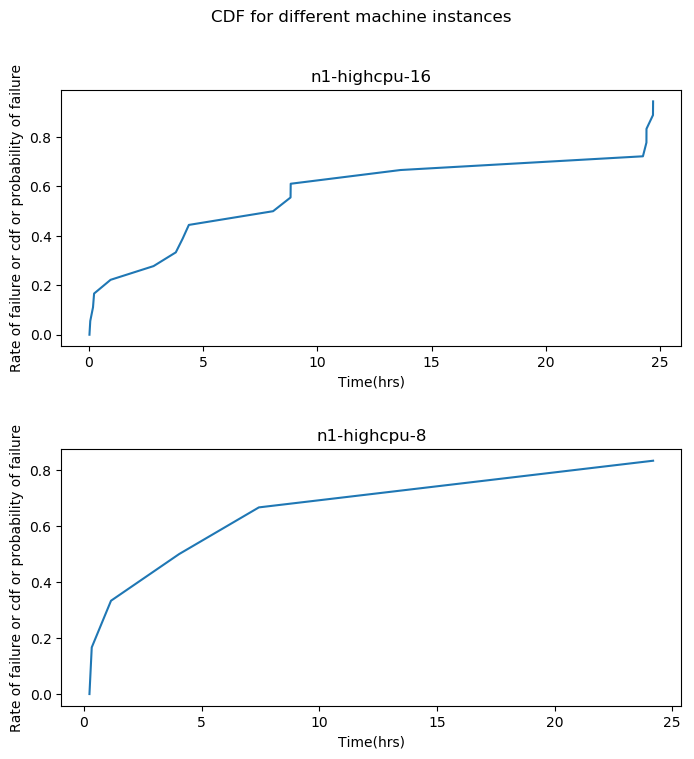

In [15]:
#Filtering data based on machine type
import json
import pandas as pd
import numpy as np
import time
import datetime
import dateutil.parser 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import math
from scipy.integrate import quad

#Instance types as a dic
instance_info = pd.read_csv('instances-m12.txt',delim_whitespace=True, header=None)
instances = pd.Series(instance_info[2].values,index=instance_info[0].values).to_dict()
del instances['NAME']

def ttl_in_minutes(start_time, end_time):
    s=dateutil.parser.parse(start_time)
    e=dateutil.parser.parse(end_time)
    diff = e-s
    return diff.total_seconds()

with open('m12.json') as json_file:  
    data = json.load(json_file)

out = dict()
for entry in data:
    eid = entry['id']
    iname = entry['targetLink']
    if entry['operationType']=='insert':
        out[iname] = (entry, np.nan)

#Adding time data
for entry in data:
    eid = entry['id']
    iname = entry['targetLink']      
    if entry['operationType']=='compute.instances.preempted':
        if iname in out:
            orig_entry = out[iname][0]
            start_time = orig_entry['insertTime']
            end_time = entry['insertTime']
            ttl = ttl_in_minutes(start_time, end_time)
            out[iname] = (orig_entry, ttl) 
            
#removing the datapoint which did not have endtime
for i in list(out):
    if np.isnan(out[i][1]):
        out.pop(i)

#Creating lists for eah machine type
all_data = dict()  
for key, value in out.items():   
    iname = key.split('/')[-1]
    if iname in instances:
        if instances[iname] in all_data:
            all_data[instances[iname]].append(value[1]/3600.0)
        else:
            all_data[instances[iname]] = [value[1]/3600.0]

#Sorting            
for key, value in all_data.items():
    all_data[key] = np.sort(all_data[key])
    
#plotting 
figure = plt.figure()
figure.set_size_inches(8, 8)
figure.subplots_adjust(hspace=0.4, wspace=0.2)
plt.suptitle('CDF for different machine instances') 
#ax = figure.add_subplot(111)
plot_count=1
grid_size=str(len(all_data))+'1'
for key, value in all_data.items():
    y = np.linspace(0,1,len(all_data[key]), endpoint=False)
    axi = figure.add_subplot(grid_size+str(plot_count))
    #ax=plt.subplot(grid_size+str(plot_count))
    #plt.subplot(222)
    plt.plot(all_data[key], y)
    plt.title(key)
    plt.xlabel("Time(hrs)")
    plt.ylabel("Rate of failure or cdf or probability of failure")
    plot_count+=1
    #save the file
    data = np.column_stack((all_data[key],y))
    np.savetxt('E-CDF-'+key+'.txt',data,delimiter='\t')
plt.show() 

In [120]:
all_data

{'n1-highcpu-16': array([ 0.0260625 ,  0.06134028,  0.18160167,  0.22848222,  0.95020194,
         2.8316275 ,  3.80477361,  4.10479417,  4.37640194,  8.063095  ,
         8.82711667,  8.83354361, 13.6397875 , 24.24876556, 24.40241444,
        24.40457083, 24.6886675 , 24.69390833]),
 'n1-highcpu-8': array([ 0.23723083,  0.33425667,  1.15291306,  4.04760778,  7.43600111,
        24.18591611])}

Text(0,0.8,'R = 1.22083*10**-6,   t0 = 12.2482,   tau = 0.910722,   C = 0.363843')

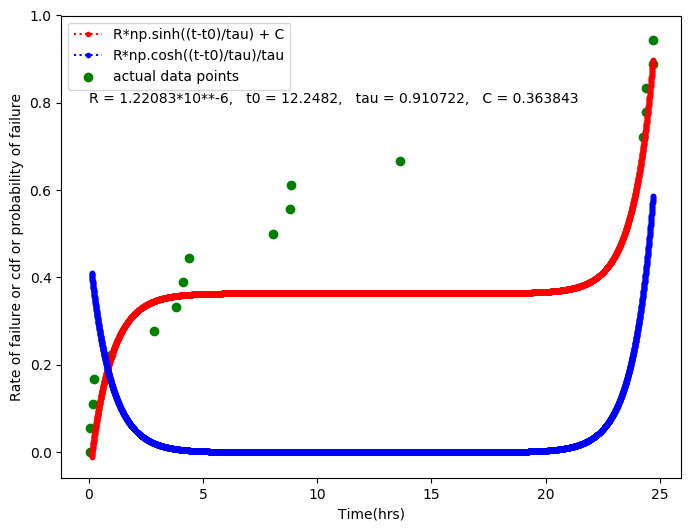

In [12]:
R = 1.22083*10**-6
t0 = 12.2482
tau = 0.910722
C = 0.363843

plt.figure(figsize=(8, 6))

#time data
t=np.linspace(0.11144944, 24.70971972, 10000)

#load data
data = np.loadtxt('E-CDF-n1-highcpu-16.txt', delimiter='\t')
#plot data points
plt.scatter(data[:,0], data[:,1], c='green', label='actual data points')

#Plot the fitted function
P= lambda t: R*np.sinh((t-t0)/tau) + C
plt.plot(t, P(t), c= "red", marker='.', linestyle=':', label='R*np.sinh((t-t0)/tau) + C')

#differentiation of the funtion
dP = lambda t: R*np.cosh((t-t0)/tau)/tau
plt.plot(t, dP(t), c= "blue", marker='.', linestyle=':', label='R*np.cosh((t-t0)/tau)/tau')
plt.legend()
plt.xlabel("Time(hrs)")
plt.ylabel("Rate of failure or cdf or probability of failure")


#Plot text
txt = "R = 1.22083*10**-6,   t0 = 12.2482,   tau = 0.910722,   C = 0.363843"
plt.text(0,0.8,txt)


In [14]:
#Analytical solution
#intergration to find the expected value 0-24 hrs
# iP = R*tau*np.cosh((t-t0)/tau) + C*t
IP = lambda t: R*tau*np.cosh((t-t0)/tau) + C*t
t=24
ip_upper_bound = IP(t)
t=0
ip_lower_bound = IP(t)
#accroding to mean value theorm
expected_value = (ip_upper_bound - ip_lower_bound)/(24-0)
expected_value

0.35709727633585514

In [24]:
#Numerical Integration
P= lambda t: R*np.sinh((t-t0)/tau) + C
I = quad(P, 0, 24)
#accroding to mean value theorm
expected_value = I[0]/24
expected_value

0.35709727633585525